In [1]:
import torch 
import numpy as np
import pandas  as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [73]:
#r""" taking a closer look into the network class


class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 6 , kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels= 12 , kernel_size=5)
        
        self.fc1 = nn.Linear(in_features= 12*4*4 , out_features= 120)
        self.fc2 = nn.Linear(in_features= 120, out_features= 60)
        self.out = nn.Linear(in_features= 60, out_features= 10)

    def forward(self,t):
        
        #1 inpput layer 
        
        t = t
        
        #2 hidden conv layer
        
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2 , stride = 2)
        
        #3 hidden conv layer 
        
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2 , stride = 2)
        
        #4 Linear layer 
        
        t = t.reshape(-1, 12*4*4)     #flattening is hapening here
        t = self.fc1(t)
        t = F.relu(t)

        
        #5 Linear layer 
        
        t = self.fc2(t)
        t = F.relu(t)
        
        #6 output layer
        
        t = self.out(t)
        # t = F.softmax(t,dim = 0)    but this line is not required because we will predict the output later and softmax will be used explicitly later
        return t
        
#loading data from url of Mnist

train_set = torchvision.datasets.FashionMNIST(
        root = './data'
        ,train = True
        ,download=True
        ,transform = transforms.Compose([
            transforms.ToTensor()
        ])
    
)

        
data_loader = torch.utils.data.DataLoader(train_set,
                    batch_size= 100                  
                    )
batch = next(iter(data_loader))
images,labels = batch

In [3]:
mynet = Network()
preds = mynet(images)

# Calculating the loss 

In [5]:
loss = F.cross_entropy(preds,labels)
loss.item()

2.3140082359313965

# Calculating the gradient 

In [6]:
print(mynet.conv1.weight.grad)

None


In [7]:
#the oputput is none bcause no gradient has yet been calculated as no back propagation has occured

# so we call the backward function now to find the gradients 

loss.backward()   # calculating the gradient 


In [8]:
print(mynet.conv1.weight.grad.shape) # the output looks like the weight tensor we saw earlier


torch.Size([6, 1, 5, 5])


# Updating the Gradient

In [9]:
my_optimizer = optim.Adam(mynet.parameters(), lr= .001)
my_optimizer.step()  

# Wrap up

In [4]:
def get_num_correct(preds,labels):
    
    return preds.argmax(dim = 1).eq(labels).sum().item()



In [74]:


test_net = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(test_net.parameters(), lr=0.01)


for epoch in range(5):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:                      # Get Batch
        images, labels = batch

        preds = test_net(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights
        total_loss += loss.item()
        
        total_correct += get_num_correct(preds,labels)

    print("epoch:", epoch  , "total loss:", total_loss, "total correct:" ,total_correct )




epoch: 0 total loss: 328.37875857949257 total correct: 47704
epoch: 1 total loss: 235.34097290039062 total correct: 51332
epoch: 2 total loss: 220.23927380144596 total correct: 51805
epoch: 3 total loss: 210.4548183977604 total correct: 52191
epoch: 4 total loss: 201.314255297184 total correct: 52542


# now lets build the confusion matrix

In [52]:
r"""#@torch.no_grad()                        #we are going to predict the output so no need to keep track of the gradient values(mmory utilization)
def get_all_preds(model,loader):
    
    all_preds = torch.tensor([])
    for batch in loader:
        images, lables = batch
        preds = model(images)
        all_preds = torch.cat((all_preds,preds),dim = 0)
    return all_preds

        

In [61]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [62]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
    train_preds = get_all_preds(test_net, prediction_loader)

In [63]:
train_preds.shape

torch.Size([60000, 10])

In [64]:
preds_correct = get_num_correct(train_preds, train_set.targets)
preds_correct

53392

In [65]:
print("total correct predictions:" , preds_correct)
print("accuracy:" , preds_correct/len(train_set))

total correct predictions: 53392
accuracy: 0.8898666666666667


In [24]:
stacked = torch.stack((train_set.targets, train_preds.argmax(dim=1)),dim=1)

In [26]:
stacked.shape

torch.Size([60000, 2])

In [27]:
stacked[0].tolist()

[9, 9]

In [34]:
cmt = torch.zeros(10,10,dtype = torch.int32)
for p in stacked:
    true_label,predicted_label = p
    cmt[true_label,predicted_label] = cmt[true_label,predicted_label]+1

In [35]:
cmt

tensor([[5485,   11,  127,  126,   10,    1,  188,    0,   52,    0],
        [  34, 5868,    6,   76,    6,    0,    6,    0,    4,    0],
        [  73,    4, 4931,   63,  475,    1,  400,    0,   52,    1],
        [ 211,   75,   40, 5470,  114,    1,   83,    0,    6,    0],
        [  17,    8,  535,  282, 4700,    1,  431,    0,   26,    0],
        [   0,    0,    0,    1,    0, 5733,    1,  117,   24,  124],
        [1415,   14,  713,  129,  491,    0, 3153,    0,   85,    0],
        [   0,    0,    0,    0,    0,   74,    0, 5728,   18,  180],
        [  12,    3,   18,   27,   18,    5,   26,    2, 5887,    2],
        [   0,    0,    0,    2,    0,   19,    0,  171,   10, 5798]], dtype=torch.int32)

In [39]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


In [42]:
cm = confusion_matrix(train_set.targets , train_preds.argmax(dim=1))

In [44]:
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5485,   11,  127,  126,   10,    1,  188,    0,   52,    0],
       [  34, 5868,    6,   76,    6,    0,    6,    0,    4,    0],
       [  73,    4, 4931,   63,  475,    1,  400,    0,   52,    1],
       [ 211,   75,   40, 5470,  114,    1,   83,    0,    6,    0],
       [  17,    8,  535,  282, 4700,    1,  431,    0,   26,    0],
       [   0,    0,    0,    1,    0, 5733,    1,  117,   24,  124],
       [1415,   14,  713,  129,  491,    0, 3153,    0,   85,    0],
       [   0,    0,    0,    0,    0,   74,    0, 5728,   18,  180],
       [  12,    3,   18,   27,   18,    5,   26,    2, 5887,    2],
       [   0,    0,    0,    2,    0,   19,    0,  171,   10, 5798]])

In [47]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
classes = ('T-shirt','trouser','pull-over', 'dress','coat','sandal','shirt','sneaker','bag','ankle-coat')

Confusion matrix, without normalization
[[5485   11  127  126   10    1  188    0   52    0]
 [  34 5868    6   76    6    0    6    0    4    0]
 [  73    4 4931   63  475    1  400    0   52    1]
 [ 211   75   40 5470  114    1   83    0    6    0]
 [  17    8  535  282 4700    1  431    0   26    0]
 [   0    0    0    1    0 5733    1  117   24  124]
 [1415   14  713  129  491    0 3153    0   85    0]
 [   0    0    0    0    0   74    0 5728   18  180]
 [  12    3   18   27   18    5   26    2 5887    2]
 [   0    0    0    2    0   19    0  171   10 5798]]


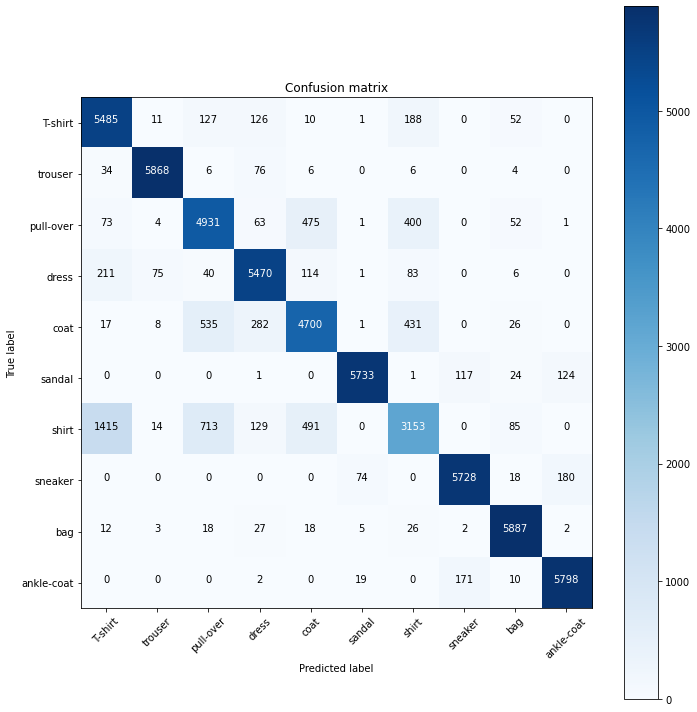

In [54]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,classes)